<a href="https://colab.research.google.com/github/asokraju/Power-Converters/blob/master/DC_Microgrid_gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Direct current Microgrid



In the we present the kron reduced model for a 4-node (connected) Direct Current Microgrid:

Analytical Model

\begin{align}
		\begin{split}
            L\dot{I}_{t} & =- V-R_tI + V_s \cdot u\\
            L_t\dot{I} & = - R I_t -\mathcal{B}^\top V\\
            C\dot{V} & = I + \mathcal{B}I_t - GV,		
		\end{split}
\end{align}

The parameters are:


*   L - DGU Inductance
*   C - DGU Capacitance
*   R - DGU Series Resistance
*   G - DGU Load Impedance
*   $V_s$ - DGU Source Voltage
*   $L_t$ - Line Inductances
*   $R_t$ - Line Resistances

The state variables:
*  $I\geq 0$ - Source current through the inductors
*  $V\geq 0$ - load voltage across the Capacitors
* $I_t \in \mathbb{R}^4$ - Line currents through the inductors

Input:
* $u\in (0,1)$ - duty-ratio
* To symmetrize the action space, we use transformed the input to $a = 2u -1$ $\implies a \in (-1,1)$.

## Reward function

The Objective is to find an optimal policy for $u$ such that the Voltage $V$ across the capacitor is $V_d$. Consequently, we define the reward function as:

\begin{align}
r(I,V, u) & = - \|V-V_d\|_2^2 
\end{align}

## For 

#Gym Model

In [2]:
# Imports
import numpy as np
import gym
from gym import spaces
import networkx
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
class Buck_micrgrid(gym.Env):
    """
    Buck converter model following gym interface
    We are assuming that the switching frequency is very High
    Action space is continious
    """
    metadata = {'render.modes': ['console']}

    def __init__(self, dt = 1e-5):
        super(Buck_micrgrid, self).__init__()

        #parameters
        self.Vs = np.array([400, 400, 400, 400])
        self.L = np.diag(np.array([1.8, 2.0, 3.0, 2.2])*1e-3)
        self.C = np.diag(np.array([2.2, 1.9, 2.5, 1.7])*1e-3)
        self.R = np.diag(np.array([1.5, 2.3, 1.7, 2.1])*0)
        self.G =  np.diag(1/np.array([16.7, 50, 16.7, 20]))

        self.Lt = np.diag(np.array([2.1, 2, 3, 2.2])*1e-6)
        self.Rt = np.diag(np.array([7, 5, 8, 6])*1e-2)

        """
        W = inv(diag([0.4 0.2 0.15 0.25]));
        D = 100*[1 -1 0 0; -1 2 -1 0; 0 -1 2 -1; 0 0 -1 1];
        B = [-1 0 0 -1;
              1 -1 0 0; 
              0 1 -1 0; 
              0 0 1 1  ];
        """
        #Graph structure
        self.inc_mat = np.array([[-1, 0, 0, -1],
                          [1, -1, 0, 0], 
                          [0, 1, -1, 0], 
                          [0, 0, 1, 1  ]])
        self.adj_mat = (np.dot(self.inc_mat, self.inc_mat.T)-2*np.eye(4)).astype(int)
        self.Graph = nx.from_numpy_matrix(self.adj_mat)
        self.pos = nx.spring_layout(self.Graph) #networkx.random_layout(G)
        self.options = {
            'node_color': 'red',
            'node_size': 1300,
            'width': 1,
            'arrowstyle': '-|>',
            'arrowsize': 12,
            'pos' : self.pos}
        

        #step size; since L and C are very low, the ode becomes stiff
        #For the default parameters the step size should in the order of 1e-6
        self.T = dt

        #the steady-state equilibrium of the system is
        self.Vdes = np.array([380, 380, 380, 380])
        self.Itdes = -np.dot(np.linalg.inv(self.Rt), np.dot(self.inc_mat.T, self.Vdes))
        self.Ides = np.dot(self.G, self.Vdes) - np.dot(self.inc_mat, self.Itdes)

        self.udes = (1/self.Vs) * (np.dot(self.R, self.Ides) + self.Vdes)
        self.action_des = 2 * self.udes - 1
        if any(self.Vs <= self.Vdes):
            raise ValueError("for buck converter desired voltage should be less the source Voltage: Vdes < Vs ")
        
        #The control action is duty-ratio which lies between 0 and 1 (We are assuming that the switching frequency is very High)
        #However, RL algos work with symmetric control actions 
        # hence we transform the action space between -1 and 1
        # action = 2*duty-ratio -1
        #duty-ratio = 0.5*(action + 1)

        self.action_space = spaces.Box(low=np.array([-1, -1, -1, -1]), high=np.array([+1, +1, +1, +1], dtype=np.float64))
        
        low_obs = np.full(shape = (12,), fill_value = -np.inf, dtype=np.float64)
        high_obs = np.full(shape = (12,), fill_value = np.inf, dtype=np.float64)

        self.observation_space = spaces.Box(low = low_obs, high = high_obs, dtype=np.float64)
        
        self._get_state()
    
    def _get_state(self):
        #initializing the state vector near to the desired values
        I = np.random.uniform(low = self.Ides*0.9, high = self.Ides*1.1)
        It = np.random.uniform(low = self.Itdes*0.9, high = self.Itdes*1.1)
        V = np.random.uniform(low = self.Vdes*0.9, high = self.Vdes*1.1)
        self.state = np.concatenate([I, It, V])

    def _set_state(self, I, It, V):
        #using this function we can change the state variable
        self.state = np.concatenate([I, It, V])

    def desired(self):
        #Provides the steady-state variables
        return np.array([self.Ides, self.Itdes, self.Vdes, self.udes, self.action_des])

    def reset(self):
        """
        Important: re-initializing the state vector near to the desired values
        :return: (np.array) 
        """
        #self.state = np.array(np.random.normal([self.Ides , self.Vdes], 5)).astype(np.float32)
        self._get_state()
        return self.state
    
    def step(self, action):

        temp_u = (1 + action[0])/2

        u = np.clip(temp_u, 0, 1)

        i = self.state[0:4]
        it = self.state[4:8]
        v = self.state[8:12]

        didt = np.dot(self.R, i) + v - u*self.Vs
        didt = -np.dot(np.linalg.inv(self.L), didt)

        ditdt = np.dot(self.Rt, it) + np.dot(self.inc_mat.T, v)
        ditdt = -np.dot(np.linalg.inv(self.Lt), ditdt)

        dvdt = i + np.dot(self.inc_mat, it)- np.dot(self.G, v)
        dvdt = np.dot(np.linalg.inv(self.C), dvdt)



        new_i = i + self.T * didt
        new_it = it + self.T * ditdt
        new_v = v + self.T * dvdt

        self.state = np.concatenate([new_i, new_it, new_v]).astype(np.float32)

        # normalize the rewards
        self.reward = -np.mean((new_v-self.Vdes)**2)
        self.done = False
        return self.state, self.reward, self.done, {}

    def render(self, mode='console'):
        # Prints the error between the desired values and their corresponding states
        ei = self.state[0:4] - self.Ides
        eit = self.state[4:8] - self.Itdes
        ev = self.state[8:12] - self.Vdes
        if mode != 'console':
            raise NotImplementedError()
        # agent is represented as a cross, rest as a dot
        print("I-Ides = {:.2f}, It-Itdes = {:.2f}, V-Vdes = {:.2f}".format(ei, eit, ev))

    def network_graph(self):
        networkx.draw_networkx(self.Graph, arrows=True, **self.options)

    def get_node(self, node_index):
        # use this after using step function
        # given index of the node, the function will return its current states i.e [current, voltage, the net line curent] and its reward 
        #node_index : 0 - 3
        i = self.state[0:4]
        v = self.state[8:12]
        o_it = np.dot(self.inc_mat, self.state[4:8])
        node_reward = -(v[node_index]- self.Vdes[node_index])**2
        node_state = np.array([i[node_index], v[node_index], o_it[node_index]])
        return node_state, node_reward

    def close(self):
        pass

#Testing:

In [4]:
def plot_signals(data, Ides, Itdes, Vdes, dt = 1e-5):
    number_of_colors = data.shape[1]
    #color = ['r', 'b']
    des1 = np.array([Ides, Itdes, Vdes])
    title_nodes = ['Node - 1', 'Node - 2', 'Node - 3', 'Node - 3']
    title_state = ['DGU current', 'Line current', 'Load Voltage']
    temp = 0
    for j in range(3):
        des = des1[j]
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize = (24,4))
        time = np.array(range(data.shape[0]), dtype=np.float32)*dt
        for i in range(4):
            ax[i].plot(time, data[:, i+temp])
            ax[i].plot(time, np.full(data[:,i+temp].shape[0], des[i]), marker = '.')
            ax[i].set_ylim(des[i]-50, des[i]+50)
            ax[i].set_title(title_nodes[i], fontsize=15)
            ax[i].set_xlabel('Time', fontsize=10)
        fig.suptitle(title_state[j], fontsize=20)
        plt.show()
        temp = temp + 4

##Testing steady with desired input

In [13]:
env = Buck_micrgrid(dt =1e-5)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
#collecting samples

print(env.reset())

obs = []
N_steps = int(1e5)
for i in range(N_steps):
    s, r, _, _ = env.step(env.action_des)
    obs.append(s)
    #print(s)

trajectory = np.concatenate(obs).reshape((N_steps ,env.observation_space.shape[0]))

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[ 24.15863283   6.87020068  22.27457309  20.03959035   0.
   0.           0.           0.         409.26333719 412.14026517
 382.28309087 352.21001863]


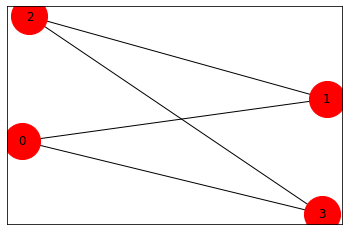

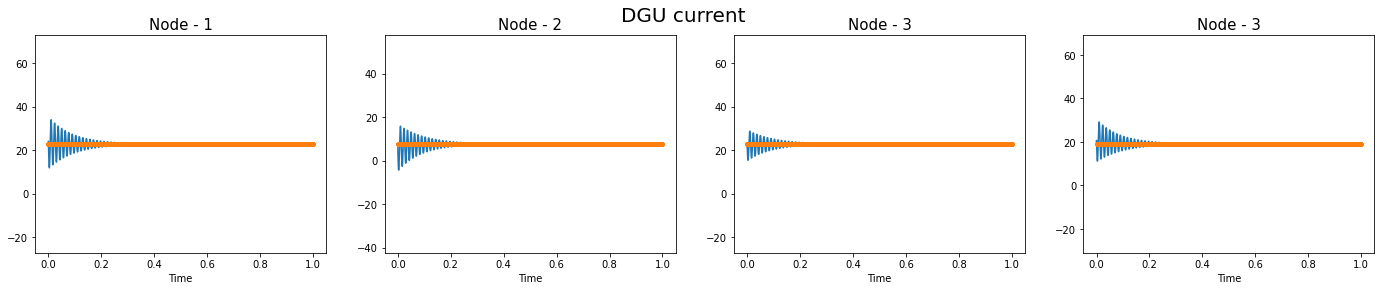

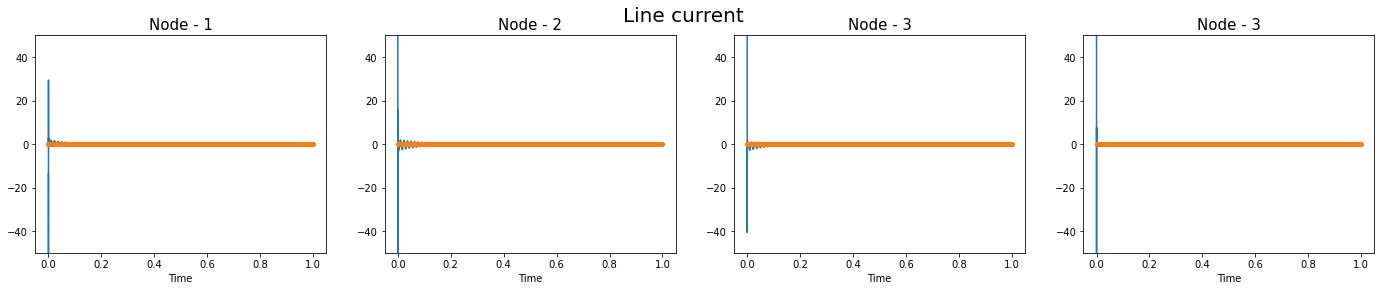

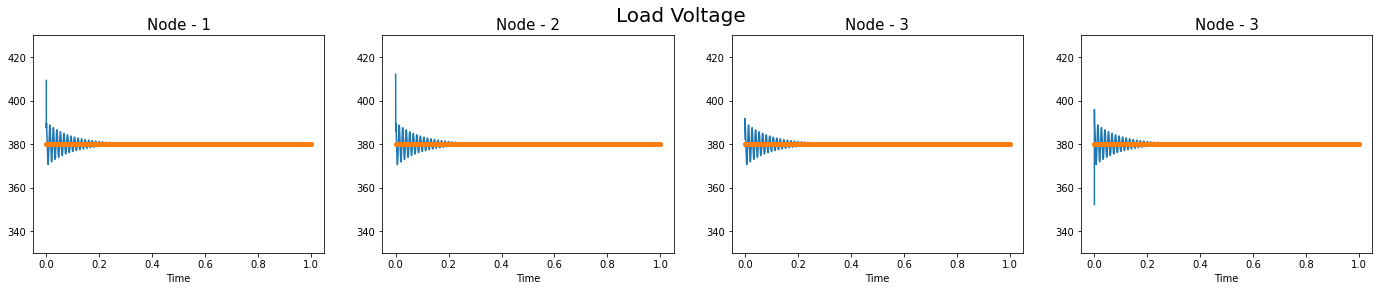

In [6]:
env.network_graph()

plot_signals(trajectory, env.Ides, env.Itdes, env.Vdes, dt = 1e-5)

## Testing for some other steady state

In [7]:
print(env.reset())

obs = []
N_steps = int(1e5)
for i in range(N_steps):
    s, r, _, _ = env.step(env.action_des - 0.1)
    obs.append(s)
    #print(s)

trajectory = np.concatenate(obs).reshape((N_steps ,env.observation_space.shape[0]))

[ 22.40170903   7.38905232  23.05357417  17.45478019   0.
   0.           0.           0.         387.55119925 358.61546365
 364.74673266 346.32827523]


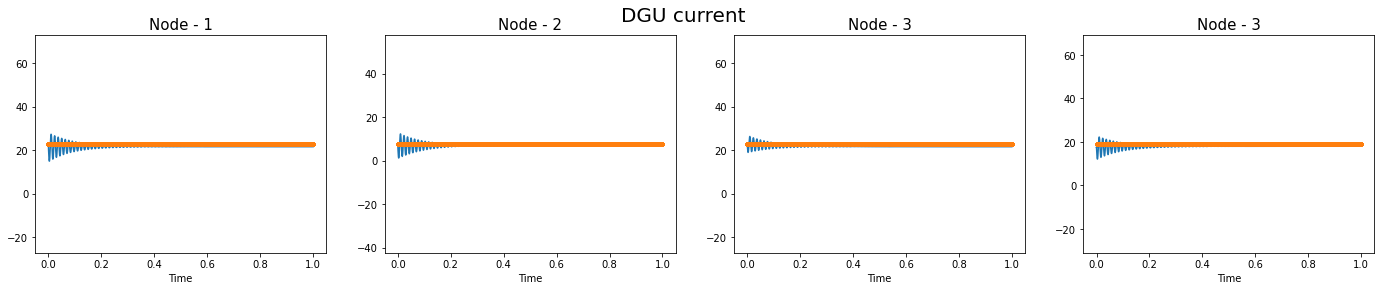

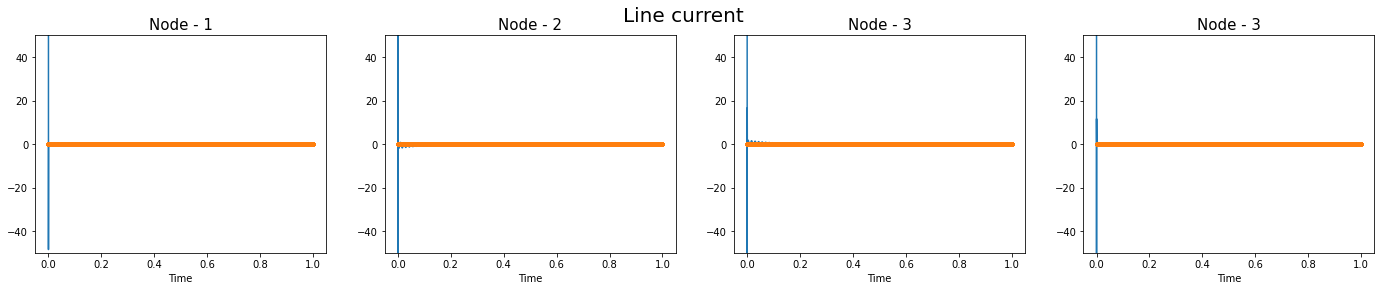

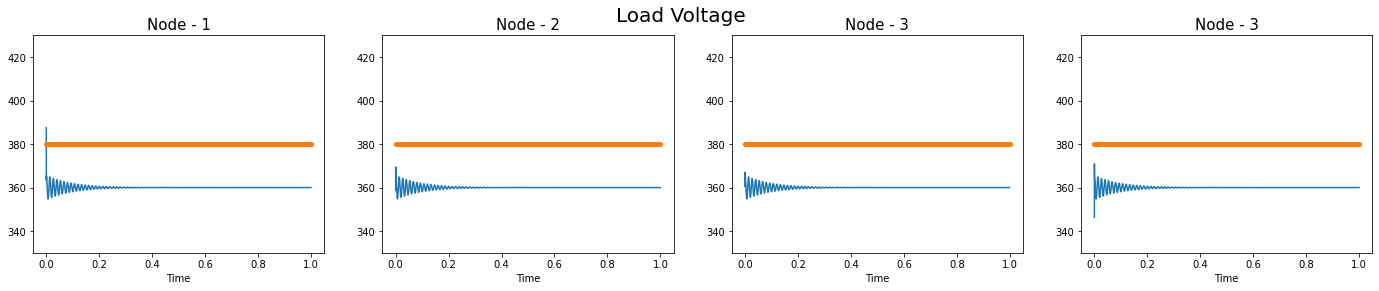

In [8]:
plot_signals(trajectory, env.Ides, env.Itdes, env.Vdes, dt = 1e-5)

##State measurements of each node

In [33]:
for j in range(4):
    node_state, node_reward = env.get_node(j)
    print('Node -- {}, state: {}, reward:{:f}'.format(j, node_state, node_reward))

Node -- 0, state: [ 24.89770641 351.65995889   0.        ], reward:-803.157930
Node -- 1, state: [  8.13364803 383.66931055   0.        ], reward:-13.463840
Node -- 2, state: [ 24.29928321 389.04829049   0.        ], reward:-81.871561
Node -- 3, state: [ 19.65570009 365.68503775   0.        ], reward:-204.918144
